# Learning From Data HW06

# Overfitting and Deterministic Noise

# 1

Using a subset of the hypothesis set will in general increase the bias (the deterministic noise).

**Alternative B**

# Regularization with Weight Decay

Download training and test set.

In [4]:
import requests

try:
    with open("in.dta", "x") as f_in:
        request_in = requests.get("http://work.caltech.edu/data/in.dta")
        f_in.write(request_in.text)
        print("Downloaded training data")
except FileExistsError as e:
    print("Training data already downloaded")

try:
    with open("out.dta", "x") as f_out:
        request_out = requests.get("http://work.caltech.edu/data/out.dta")
        f_out.write(request_out.text)
        print("Downloaded test data")
except FileExistsError as e:
    print("Test data already downloaded")

Training data already downloaded
Test data already downloaded


Load data.

In [5]:
import numpy as np
data_train = np.loadtxt("in.dta")
X_train, y_train = data_train[:,:2], data_train[:,2]

data_test = np.loadtxt("out.dta")
X_test, y_test = data_test[:,:2], data_test[:,2]


Look at the data.

In [6]:
i_below = np.flatnonzero(y_training == -1)
i_above = np.flatnonzero(y_training == 1)
assert i_below.shape[0] + i_above.shape[0] == y_training.shape[0]

import matplotlib.pyplot as plt


plt.title("Training data")
plt.scatter(X_train[i_below,0], X_train[i_below,1])
plt.scatter(X_train[i_above,0], X_train[i_above,1])
plt.legend(["+1", "-1"])
plt.show()

NameError: name 'y_training' is not defined

# 2

Run linear regression on the training set after performing the non-linear transformation.

Since we already implemented nonlinear regression from scratch in the previous homework, I will use sklearn this time.

    class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)[source]¶

In [ ]:
import sklearn as sk

def phi(X):
    Z = np.zeros((X.shape[0],  8))
    Z[:,0] = 1
    Z[:,1] = X[:,0]
    Z[:,2] = X[:,1]
    Z[:,3] = X[:,0]**2
    Z[:,4] = X[:,1]**2
    Z[:,5] = X[:,0] * X[:,1]
    Z[:,6] = np.abs(X[:,0] - X[:,1])
    Z[:,7] = np.abs(X[:,0] + X[:,1])
    return Z

# Transform the data
Z_train = phi(X_train)

# Fit the data
Z = Z_train
w_tilde = np.linalg.solve(Z.T @ Z, Z.T @ y_train)

def predict(X):
    Z = phi(X)
    return np.sign(Z @ w_tilde)

# View the contour
xx = np.linspace(-1, 1)
yy = np.linspace(-1, 1)
XX, YY = np.meshgrid(xx, yy)
X_plot = np.column_stack([XX.reshape(-1), YY.reshape(-1)])
y_plot = predict(X_plot)
ZZ = y_plot.reshape(XX.shape)
plt.title("Training data fit")
plt.contourf(XX, YY, ZZ)
plt.colorbar()
plt.scatter(X_train[i_below,0], X_train[i_below,1])
plt.scatter(X_train[i_above,0], X_train[i_above,1])
plt.show()

Compute in-sample classification error.

In [ ]:
E_in = np.mean(predict(X_train) != y_train)
print("E_in =", E_in)

Compute of-of-sample classification error

In [ ]:
E_out = np.mean(predict(X_test) != y_test)
print("E_out =", E_out)

Which is most similar to **Alternative A: (0.03, 0.08)**

# 3

Add weight decay with $\lambda = 10^k$

In [ ]:
# Transform the data
Z_train = phi(X_train)

for k in range(-5, 5):
    # Fit the data
    Z = Z_train
    w_tilde = np.linalg.solve(Z.T @ Z + 10**k*np.identity(Z.shape[1]), Z.T @ y_train)

    def predict(X):
        Z = phi(X)
        return np.sign(Z @ w_tilde)

    # View the contour
    xx = np.linspace(-1, 1)
    yy = np.linspace(-1, 1)
    XX, YY = np.meshgrid(xx, yy)
    X_plot = np.column_stack([XX.reshape(-1), YY.reshape(-1)])
    y_plot = predict(X_plot)
    ZZ = y_plot.reshape(XX.shape)
    plt.title("Training data fit")
    plt.contourf(XX, YY, ZZ)
    plt.colorbar()
    plt.scatter(X_train[i_below,0], X_train[i_below,1])
    plt.scatter(X_train[i_above,0], X_train[i_above,1])
    plt.show()

    # Print in/out error
    print("k", k)
    E_in = np.mean(predict(X_train) != y_train)
    print("E_in =", E_in)
    E_out = np.mean(predict(X_test) != y_test)
    print("E_out =", E_out)

For k=-3: Almost identical results. 0.03, 0.08. **3: Alternative D**

Better out of sample error with regularization. In sample is the same.

# 4

Need to compute euclidean distance to alternatives

In [ ]:
E_in = 0.37142857142857144
E_out = 0.436
print("a", np.sqrt((E_in - 0.2)**2 + (E_out - 0.2)**2))
print("b", np.sqrt((E_in - 0.2)**2 + (E_out - 0.3)**2))
print("c", np.sqrt((E_in - 0.3)**2 + (E_out - 0.3)**2))
print("d", np.sqrt((E_in - 0.3)**2 + (E_out - 0.4)**2))
print("e", np.sqrt((E_in - 0.4)**2 + (E_out - 0.4)**2))

**Alternative E** is the closest.

Both the in-sample and out-of-sample performance is just horrible.

# 5

The best choice for $k$ is -1, giving the lowest out-of-sample classification error. **Alternative C**

# 6

We get E_out = 0.056, closest to **Alternative B, 0.06**

# Regularization for Polynomials

## Interlude: Legendre polynomials

There are many ways to discover the Legendre polynomials. Instead of just importing them from sklearn or whatever I will take a stab at computing them myselves, using the following requirements:

1. Orthogonal over the interval [-1, 1]

$$ \int_{-1}^1 P_m(x) P_n(x)\,dx = 0\quad \text{ if } n \neq m $$

2. $P_n(x)$ has degree $n$

3. $ P_n(1) = 1 $ (standardization)

We can now use Gram-Schmidt orthogonalization to produce Legendre polynomials.

The scheme is defined by:

$$P_0(x) = 1 $$
(since that is the only zeroth order polynomial that fits).

$$P_n(x) = x^n - \frac{\langle x^n,P_{n-1}\rangle}{\langle P_{n-1}, P_{n-1}\rangle} P_{n-1}(x) - \cdots - \frac{\langle x^n,P_{0}\rangle}{\langle P_{0}, P_{0}\rangle} P_{0}(x)$$

We can now iteratively compute $P_1$, then $P_2$, ..., then $P_N$ for any desired $N$.

In [ ]:
import sympy as sp
from sympy.abc import x
sp.init_printing() # Latex output
import matplotlib.pyplot as plt
import numpy as np

def inner(pi, pj):
    """Inner product between two polynomials"""
    return sp.integrate(pi*pj, (x, -1, 1))

def standardize(ptilde):
    """Standardize a polynomial so that P(1) = 1"""
    return ptilde / ptilde.subs(x, 1)

def legendre_polynomials(max_degree):
    """
    Return a list of Legendre polynomials up to `max_degree`.
    """
    ps = [
        sp.sympify("1")
    ]
    for n in range(1, max_degree+1):
        ptilde = x**n
        for j in range(0, n):
            ptilde = ptilde - inner(x**n, ps[j])/inner(ps[j], ps[j]) * ps[j]
        ps.append(standardize(ptilde))
    return ps

ps = legendre_polynomials(5)
for p in ps:
    display(p)

# Convert to NumPy functions and plot
fs = [sp.lambdify(x, p, "numpy") for p in ps]
xx = np.linspace(-1, 1)
for f in fs:
    # Broadcast needed for P0 since it returns "1" instead of [1 1 1 1...]
    plt.plot(xx, np.broadcast_to(f(xx), xx.shape))
plt.show()

Let us compare the results with SciPy's included functions.

In [ ]:
import scipy.special
sp_ps = [scipy.special.legendre(i) for i in range(6)]
for sp_p in sp_ps:
    print(sp_p)
    
for sp_p in sp_ps:
    plt.plot(xx, sp_p(xx))
plt.show()

Looks good to me!

I have now shown how it is possible to generate Legendre polynomials using symbolic Gram-Schmidt orthoganlization.

# 7

H(10, 0, 3) is equal to H2 since the weights for L3 and above are zero. Only the weights for L0, L1, L2 can be varied.

H(10, 0, 4) is a superset of H(10, 0, 3)

Thus the intersection of H(10, 0, 3) and H(10, 0, 4) is equal to H(10, 0, 3) which is again equal to H2.

**Alternative C** is correct.

# Neural Networks

My understanding is a bit lacking here, so I'll implement backpropagation from scratch to get used to it.

<Figure size 640x480 with 1 Axes>

y1 0.4974289879577021 should be 0.5
y2 -0.4959111501442342 should be -0.5
y3 -0.200130619131915 should be -0.2
y4 0.1994482484232731 should be 0.2


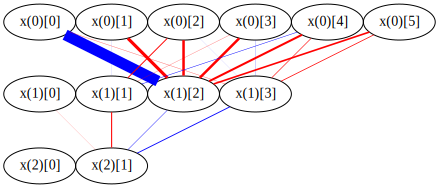

In [7]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt

class Layer:
    def __init__(self):
        pass


# Based on slides by Yaser S. Abu-Mostafa
# http://work.caltech.edu/slides/slides10.pdf
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        
    def add_input_layer(self, num_neurons):
        layer = Layer()
        layer.num_neurons = num_neurons
        layer.w = None
        layer.dw = None
        layer.dell = None
        layer.a = np.zeros((num_neurons+1,))
        layer.a[0] = 1.0
        self.layers.append(layer)
            
    def add_dense_layer(self, num_neurons):
        layer = Layer()
        layer.num_neurons = num_neurons
        prev_layer_num_neurons = self.layers[-1].num_neurons
        layer.w = 2*np.random.rand(num_neurons+1, prev_layer_num_neurons+1)-1.0
        layer.w[0,:] = 0
        layer.dw = np.zeros((num_neurons, prev_layer_num_neurons+1))
        layer.dell = np.zeros((num_neurons+1,))
        layer.s = np.zeros((num_neurons+1,))
        layer.s[0] = 1.0
        layer.a = np.zeros((num_neurons+1,))
        layer.a[0] = 1
        self.layers.append(layer)
    
    def graphviz(self):
        dot = Digraph(engine="neato")
        L = len(self.layers) - 1
        for l in range(0, L+1):
            # Nodes
            for j in range(self.layers[l].num_neurons+1):
                dot.node("x({})[{}]".format(l, j), pos="{},{}!".format(j,-1*l))
                # Forward edges
                if l < L:
                    for i in range(1, self.layers[l+1].num_neurons+1):
                        w = self.layers[l+1].w[i,j]
                        if w < 0:
                            c = "red"
                            w = -w
                        else:
                            c = "blue"
                        dot.edge(
                            "x({})[{}]".format(l, j), "x({})[{}]".format(l+1, i),
                            arrowhead="none",
                            penwidth="{}".format(w),
                            color=c
                        )
                
        display(dot)
        
    def theta(self, s):
        return np.tanh(s)
    
    def theta_derivative(self, s):
        return 1 - np.tanh(s)**2
    
    # Hard-coded for 2 layers at the moment
    def predict(self, x):
        self.layers[0].a = x
        
        self.layers[1].s = self.layers[1].w @ self.layers[0].a
        self.layers[1].a = self.theta(self.layers[1].s)
        self.layers[1].a[0] = 1.0
        
        self.layers[2].s = self.layers[2].w @ self.layers[1].a
        self.layers[2].a = self.theta(self.layers[2].s)
        self.layers[2].a[0] = 1.0
        return self.layers[2].a[1]
    
    def error(self, y_actual):
        y_predicted = self.layers[-1].a[1]
        return (y_predicted - y_actual)**2
    
    def error_derivative(self, y_actual):
        y_predicted = self.layers[-1].a[1]
        return 2*(y_predicted - y_actual)
    
    def backprop(self, x, y, learning_rate, weight_decay_rate=0):
        self.predict(x)
        L = len(self.layers)-1
        
        # Special case for output layer
        a = self.layers[L].a[1]
        self.layers[L].dell[1] = self.error_derivative(y) * (1 - a**2)
        #print("Updating dell(L)")

        # Loop through output+hidden layers, computing dell for each neuron
        for l in range(L, 1, -1): # Not including layer 1, since it's not needed
            this_layer = self.layers[l]
            prev_layer = self.layers[l-1]
            for this_j in range(1, self.layers[l].num_neurons+1):
                for prev_i in range(0, self.layers[l-1].num_neurons+1):
                    prev_layer.dell[prev_i] += (1-prev_layer.a[prev_i]**2) \
                        * this_layer.w[this_j,prev_i] \
                        * this_layer.dell[this_j]
                    #print("Updating dell(l{})({}) using w from {} to {}".format(l-1, prev_i, this_j, prev_i))

                    
        
        # Update weights hidden+output layers
        for l in range(1, L+1):
            this_layer = self.layers[l]
            prev_layer = self.layers[l-1]
            for this_j in range(1, this_layer.num_neurons+1):
                for prev_i in range(0, prev_layer.num_neurons+1):
                    dw = -learning_rate * prev_layer.a[prev_i] * this_layer.dell[this_j]
                    weight_decay = - 2*learning_rate*weight_decay_rate * this_layer.w[this_j,prev_i]
                    this_layer.w[this_j,prev_i] += dw + weight_decay
                    #print("Updating weight w({})_{},{}: += {}".format(l, this_j, prev_i, dw))
                    


nn = NeuralNetwork()
nn.add_input_layer(5)
nn.add_dense_layer(3)
nn.add_dense_layer(1)
errors = []
eta = 0.1
weight_decay_rate = 0.0001
for its in range(3000):
    eta *= 0.9999 # Decaying learning rate
    
    # Sample 1
    y1 = nn.predict(np.array([1, -0.3, 0.2, -0.5, -0.5, 0.1]))
    e1 = nn.error(0.5)
    nn.backprop(np.array([1, -0.3, 0.2, -0.5, -0.5, 0.1]), 0.5, eta, weight_decay_rate)
    
    # Sample 2
    y2 = nn.predict(np.array([1, 0.2, -0.5, -0.5, 0.1, -0.3]))
    e2 = nn.error(-0.5)
    nn.backprop(np.array([1, 0.2, -0.5, -0.5, 0.1, -0.3]), -0.5, eta, weight_decay_rate)
    
    # Sample 3
    y3 = nn.predict(np.array([1, -0.5, -0.5, 0.1, -0.3, 0.2]))
    e3 = nn.error(-0.2)
    nn.backprop(np.array([1, -0.5, -0.5, 0.1, -0.3, 0.2]), -0.2, eta, weight_decay_rate)
    
    # Sample 4
    y4 = nn.predict(np.array([1, -0.5, 0.1, -0.3, 0.2, -0.5]))
    e4 = nn.error(0.2)
    nn.backprop(np.array([1, -0.5, 0.1, -0.3, 0.2, -0.5]), 0.2, eta, weight_decay_rate)
    
    e = (e1+e2+e3+e4)/4
    errors.append(e)
    if e < 0.00001:
        break
    

plt.plot(errors)
plt.show()

# Verify that neural network has learned to predict both samples correctly
y1 = nn.predict(np.array([1, -0.3, 0.2, -0.5, -0.5, 0.1]))
y2 = nn.predict(np.array([1, 0.2, -0.5, -0.5, 0.1, -0.3]))
y3 = nn.predict(np.array([1, -0.5, -0.5, 0.1, -0.3, 0.2]))
y4 = nn.predict(np.array([1, -0.5, 0.1, -0.3, 0.2, -0.5]))
print("y1", y1, "should be 0.5")
print("y2", y2, "should be -0.5")
print("y3", y3, "should be -0.2")
print("y4", y4, "should be 0.2")
nn.graphviz()

The model successfully fits 4 points at once. Crazy over

# 8

In a fully connected Neural Network with L=2, d(0)=5, d(1)=3 and d(2)=1, how many products of the following forms are done:

1. w[l] * a[l-1]

2. w[l] * dell[l-1]

3. x[l-1] * dell[l]

for a single iteration of backpropagation? (including forward pass). Multiplications with x(0) also count.



---

In [8]:
ops1 = 0
ops2 = 0
ops3 = 0

# Forward pass, only ops_1
layer1_forward_ops1 = 3 * 6
layer2_forward_ops1 = 1 * 4
ops1 += layer1_forward_ops1 + layer2_forward_ops1

# Backward pass, compute dell for hidden layer + output layer
layer2_ops3 = 0 # Assume computing dell for output node is free
layer1_ops3 = 3 # bias neuron doesn't have a dell
ops3 += layer2_ops3 + layer1_ops3

# Any order (can loop through either forward or backward)
# Find de/dw for all weights, using de/dw = x(l-1) * dell(l) (op3)
layer2_ops2 = 4
layer1_ops2 = 3 * 6
ops2 += layer2_ops2 + layer1_ops2

print("total:", ops1+ops2+ops3)
print("Forward:", ops1)
print("Backward:", ops3)
print("Update:", ops2)


total: 47
Forward: 22
Backward: 3
Update: 22


Which is closest to **alternative D, 45**

# 9

For a neural network with 10 input units (that includes bias unit), one output unit and 36 hidden units (bias counts). The hidden units can be arrange in any number of layers.

What is the minimum possible number of weights such a network can have?

total weights 46
which is 18*2 + 10


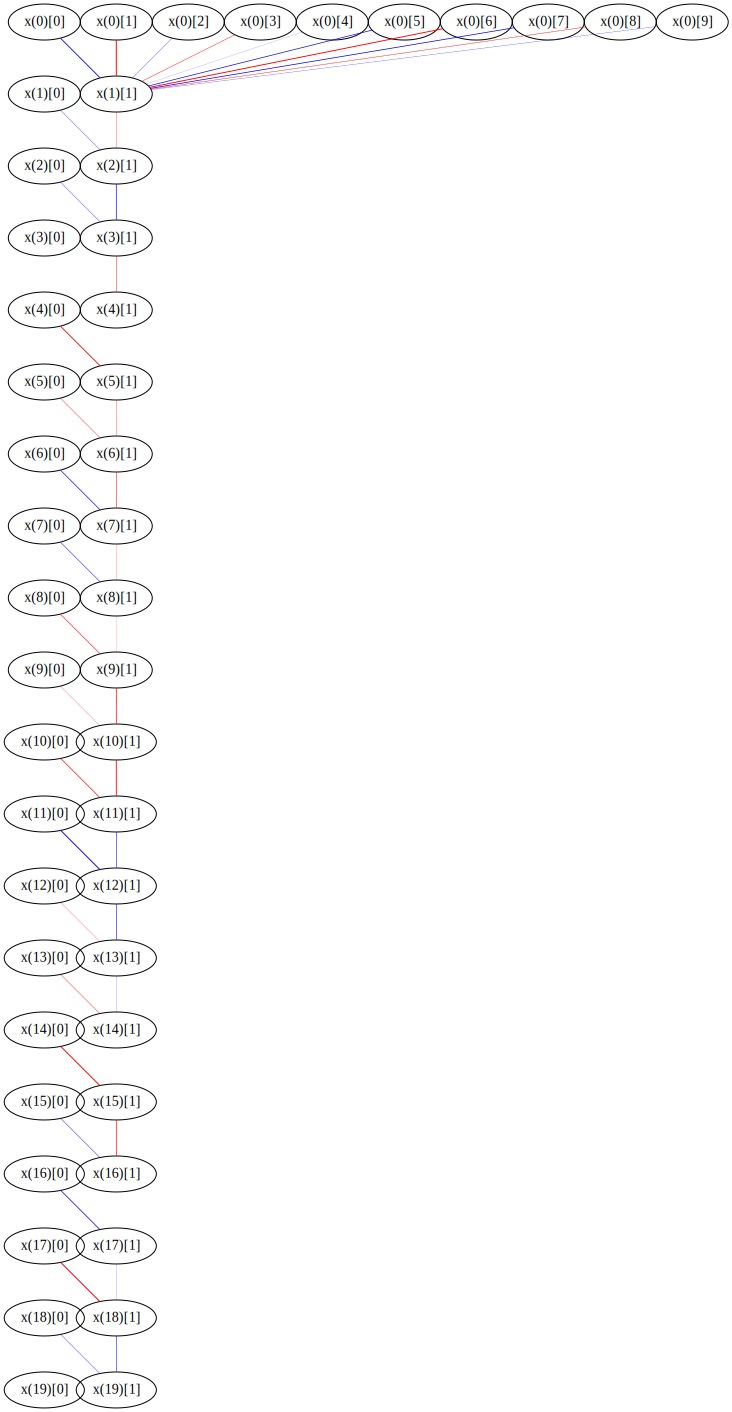

In [9]:
nn = NeuralNetwork()
nn.add_input_layer(9) # Input
for i in range(18):
    nn.add_dense_layer(1) # Hidden layer
nn.add_dense_layer(1) # Output


tot = 0
tot += 10 # input to first hidden layer
tot += 2 * 17 # 17 remaining hidden layers
tot += 2 # output layer
print("total weights", tot)
print("which is 18*2 + 10")

nn.graphviz()

**Alternative A: 46**

# 10

What is the maximum number of weights that such a network can have?

(10 input units, 36 hidden units, 1 output unit)

In [11]:
hidden_units = 36
for l1_units in range(2, 34):
    l2_units = hidden_units - l1_units
    num_weights = 0
    num_weights += (l1_units-1)*10
    num_weights += (l2_units-1)*l1_units
    num_weights += 1 * l2_units
    print(10, l1_units, l2_units, 1, "total weights", num_weights)
    
    

10 2 34 1 total weights 110
10 3 33 1 total weights 149
10 4 32 1 total weights 186
10 5 31 1 total weights 221
10 6 30 1 total weights 254
10 7 29 1 total weights 285
10 8 28 1 total weights 314
10 9 27 1 total weights 341
10 10 26 1 total weights 366
10 11 25 1 total weights 389
10 12 24 1 total weights 410
10 13 23 1 total weights 429
10 14 22 1 total weights 446
10 15 21 1 total weights 461
10 16 20 1 total weights 474
10 17 19 1 total weights 485
10 18 18 1 total weights 494
10 19 17 1 total weights 501
10 20 16 1 total weights 506
10 21 15 1 total weights 509
10 22 14 1 total weights 510
10 23 13 1 total weights 509
10 24 12 1 total weights 506
10 25 11 1 total weights 501
10 26 10 1 total weights 494
10 27 9 1 total weights 485
10 28 8 1 total weights 474
10 29 7 1 total weights 461
10 30 6 1 total weights 446
10 31 5 1 total weights 429
10 32 4 1 total weights 410
10 33 3 1 total weights 389


By choosing a 10, 22, 14, 1 configuration we end up with 510 weights total.

**Alternative E: 510**